In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import yaml
import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# era5 downloaded from Google Cloud ARCO store using era5-downloader and extracted for Antatctica domain
# https://pypi.org/project/era5-downloader/0.1.5/ 
# make ancillaries files: 
# 1. gridbox mean elevation 
# 2. tile fraction (i.e. set a single elevated ice tile) 
# 3. land sea mask 
# 4. model grid 

home       = os.path.expanduser("~")
yaml_path  = os.path.join(home, 'dirpaths.yaml')
data_dir   = yaml.safe_load(open(yaml_path))['EXTANT_DATA_PATH']


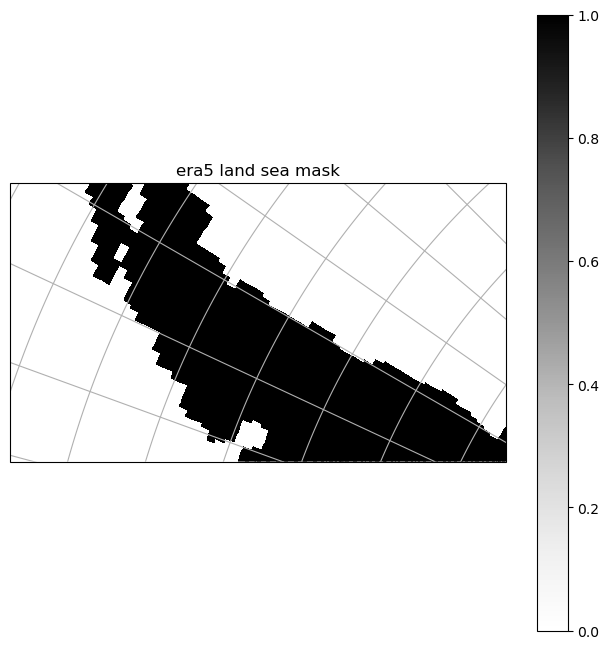

In [2]:
# plot the land sea mask
fname = 'era5-lsm-antarctica60S.nc'
fpath = os.path.join(data_dir, 'jules', 'input', 'forcing', 'era5', 'lsm', fname)
ds   = nc.Dataset(fpath, 'r')
lsm = ds.variables['lsm'][:].squeeze() 
lsm = np.where(lsm > 0.0, 1.0, 0.0).astype('float32') 
lats = ds.variables['latitude'][:]      
lons = ds.variables['longitude'][:]    
ds.close()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
#ax.set_extent([-62, -60, -67, -65], ccrs.PlateCarree()) # larsen B
#ax.set_extent([-80, -45, -75, -60], ccrs.PlateCarree()) 
ax.set_extent([298, 299, -75, -60], ccrs.PlateCarree()) # lons are 0-360 
c = ax.pcolormesh(lons, lats, lsm.squeeze(), cmap='Greys', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

plt.title("era5 land sea mask")
plt.colorbar(c)
plt.show()


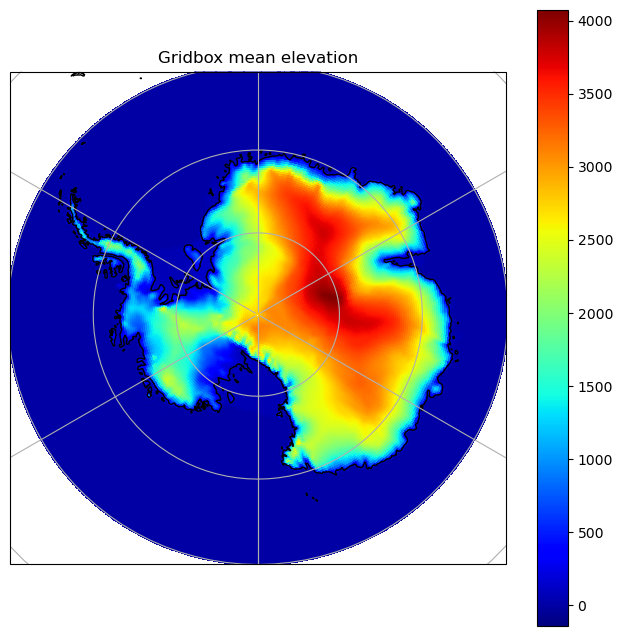

In [14]:
# calc elevation from geo potential height and plot 
fname='era5-z_surf-antarctica60S.nc'
fpath = os.path.join(data_dir, 'jules', 'input', 'forcing', 'era5', 'lsm', fname)
ds   = nc.Dataset(fpath, 'r')
z_surf = ds.variables['z_surf'][:]            
elev=z_surf / 9.80665
elev=elev.squeeze()
ds.close()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
c = ax.pcolormesh(lons, lats, elev, cmap='jet', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.title("Gridbox mean elevation")
plt.colorbar(c)
plt.show()



In [16]:
# ancillary file 1. grid box mean elevation

FILL = np.nan#np.float32(-1.0e20)

out_path = os.path.join(data_dir, 'jules', 'input', 'ancil', 'era5', 'elev-antarctica60S.nc')

# Create new NetCDF file
ds_out = nc.Dataset(out_path, 'w', format='NETCDF4')

# Define dimensions
ds_out.createDimension('latitude', len(lats))
ds_out.createDimension('longitude', len(lons))

# Create coordinate variables
lat_var = ds_out.createVariable('latitude', 'f4', ('latitude',))
lon_var = ds_out.createVariable('longitude', 'f4', ('longitude',))

lat_var[:] = lats
lon_var[:] = lons

lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

# Create the elevation variable
elev_var = ds_out.createVariable('elevation', 'f4', ('latitude', 'longitude'), zlib=True, fill_value=FILL)

# no negative elevations
elev = np.where(elev < 0, 0, elev)

# set ocean to fill values
#elev_masked = np.where(lsm.squeeze() == 0, FILL, elev)

elev_var[:] = elev

# Add attributes
elev_var.units = 'm'
elev_var.long_name = 'Gridbox mean surface elevation'
elev_var.standard_name = 'surface_altitude'
elev_var.missing_value = FILL

# Add global attributes
ds_out.description = 'Elevation (m) derived from ERA5 geopotential (z_surf / g)'
ds_out.source_file = fname

# Close datasets
ds_out.close()

In [24]:
# ancillary file 2. tile fraction, set a single elevated ice tile (number 9)

FILL = np.float32(-1.0e20)
ny, nx = lsm.shape

# mask of valid land points
land = np.isfinite(lsm) & (lsm > 0)

# build output: default fill, then set land layers
out = np.full((9, ny, nx), FILL, dtype='f4')
out[0:8, land] = 0.0
out[8, land]   = 1.0

# write netcdf
out_path = os.path.join(data_dir, 'jules', 'input', 'ancil', 'era5', 'era5-ice-frac-9-antarctica60S.nc')
ds_out = nc.Dataset(out_path, 'w')

ds_out.createDimension('tile', 9)
ds_out.createDimension('latitude', ny)
ds_out.createDimension('longitude', nx)

latv = ds_out.createVariable('latitude',  'f4', ('latitude',))
lonv = ds_out.createVariable('longitude', 'f4', ('longitude',))
levv = ds_out.createVariable('tile', 'i4', ('tile',))

latv[:] = lats; lonv[:] = lons; levv[:] = np.arange(9)

v = ds_out.createVariable('frac', 'f4', ('tile','latitude','longitude'),
                          zlib=True, fill_value=FILL)
v[:] = out
v.missing_value = FILL  

ds_out.close()

In [46]:
# ancillary file 3. land sea mask lsm(latitude,longitude) 

out_path = os.path.join(data_dir, 'jules', 'input', 'ancil', 'era5', 'era5-lsm-round-antarctica60S.nc')

# Create new NetCDF file
ds_out = nc.Dataset(out_path, 'w', format='NETCDF4')

# Define dimensions
ds_out.createDimension('latitude', len(lats))
ds_out.createDimension('longitude', len(lons))

# Create coordinate variables
lat_var = ds_out.createVariable('latitude', 'f4', ('latitude',))
lon_var = ds_out.createVariable('longitude', 'f4', ('longitude',))

lat_var[:] = lats
lon_var[:] = lons

lat_var.units = 'degrees_north'
lon_var.units = 'degrees_east'

# Create the lsm variable
lsm_var = ds_out.createVariable('lsm', 'f4', ('latitude', 'longitude'), zlib=True)
lsm_var[:] = lsm#.squeeze()  

# Add attributes
lsm_var.units = ''
lsm_var.long_name = 'land sea mask'
lsm_var.standard_name = 'land_sea_mask'

# Add global attributes
ds_out.description = 'era5 land sea mask'
ds_out.source_file = fname

# Close datasets
ds_out.close()

In [23]:
# ancillary file 4. era5 grid

lat2d, lon2d = np.meshgrid(lats, lons, indexing='ij')  

out_path = os.path.join(data_dir, 'jules', 'input', 'ancil', 'era5', 'era5-grid.nc')
ds = nc.Dataset(out_path, 'w', format='NETCDF4')

# Dimensions
ds.createDimension('latitude', len(lats))
ds.createDimension('longitude', len(lons))

# 2-D latitude variable
latv = ds.createVariable('latitude', 'f4', ('latitude','longitude'), zlib=True, fill_value=-1.0e20)
latv[:, :] = lat2d
latv.long_name = "Latitude of grid box centre"
latv.units = "degrees"
latv.missing_value = np.float32(-1.0e20)

# 2-D longitude variable
lonv = ds.createVariable('longitude', 'f4', ('latitude','longitude'), zlib=True, fill_value=-1.0e20)
lonv[:, :] = lon2d
lonv.long_name = "Longitude of grid box centre"
lonv.units = "degrees"
lonv.missing_value = np.float32(-1.0e20)

ds.close()


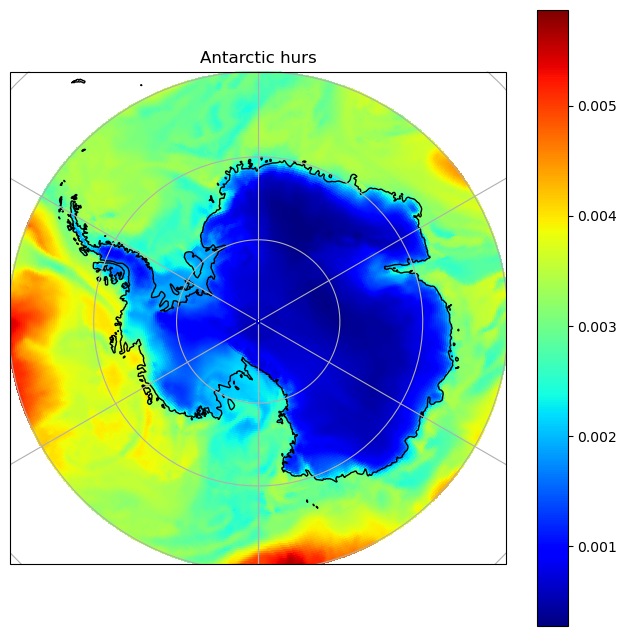

In [32]:
# checking some outputs here specific humidity - check it looks okay
fname = 'era5-huss-antarctica60S-19790101.nc'
fpath = os.path.join(data_dir, 'jules', 'input', 'forcing', 'era5', 'huss', '1979',fname)
ds   = nc.Dataset(fpath, 'r')
hurs = ds.variables['q'][0,:,:].squeeze()            
lats = ds.variables['latitude'][:]      
lons = ds.variables['longitude'][:]    
#print(ds)
ds.close()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([0, 360, -90, -60], ccrs.PlateCarree())
c = ax.pcolormesh(lons, lats, hurs.squeeze(), cmap='jet', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.title("Antarctic hurs")
plt.colorbar(c)
plt.show()

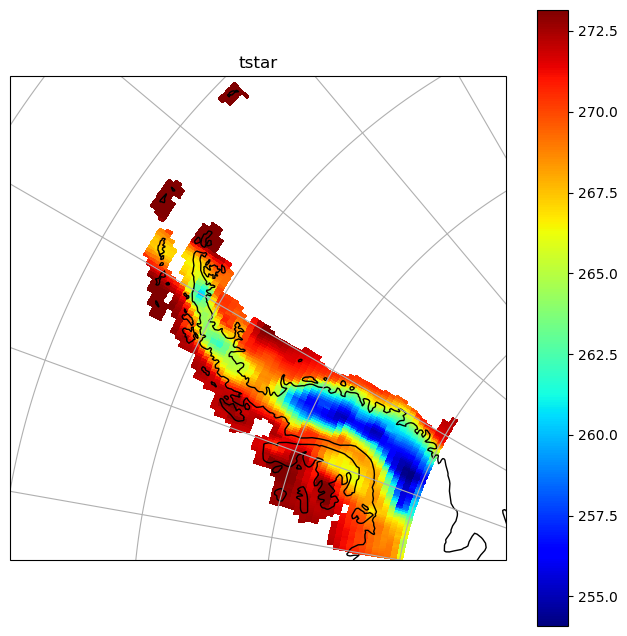

In [3]:
#ds   = nc.Dataset('/gws/nopw/j04/extant/users/sarahshannon/jules/jules_vn7.9/output/era5_gridded_peninsula/era5.vars.nc', 'r')
# plot output of vn4.7 run with a single elevated tile of 10m
ds   = nc.Dataset('/gws/nopw/j04/extant/users/sarahshannon/jules/jules_vn7.9/output/test_vn4.7/era5.vars.nc', 'r') 
tstar = ds.variables['tstar'][12,8,:,:].squeeze()            
lats = ds.variables['latitude'][:]      
lons = ds.variables['longitude'][:]    
ds.close()

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
#ax.set_extent([0, 360, -90, -60], ccrs.PlateCarree())
ax.set_extent([280, 315, -75, -60], ccrs.PlateCarree())
c = ax.pcolormesh(lons, lats, tstar.squeeze(), cmap='jet', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
plt.title("tstar")
plt.colorbar(c)
plt.show()